# DROPSINATOR


## Import

In [129]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from lmfit.models import GaussianModel

from scipy.signal import find_peaks
from scipy import optimize as optim

import uncertainties as unc


import sys
sys.path.append('../Library')

import drop_detection_tools as ddt
import uplotlib as uplt


plot_dir = '../../../Report/Plots/'
plot_dir.rstrip('/')

from importlib import reload


from tqdm import tqdm
%matplotlib inline
import csv

## Latex plot

In [2]:
FontSize = 18
plt.rc('axes',   titlesize = FontSize) # fontsize of the axes title
plt.rc('axes',   labelsize = FontSize) # fontsize of the x and y labels
plt.rc('xtick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('ytick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('legend', fontsize  = FontSize) # legend fontsize
plt.rc('figure', titlesize = FontSize) # fontsize of the figure title

matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size' :  18,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Data acquisition

name = '2-12_B-ol5-aq5'


<IPython.core.display.Javascript object>


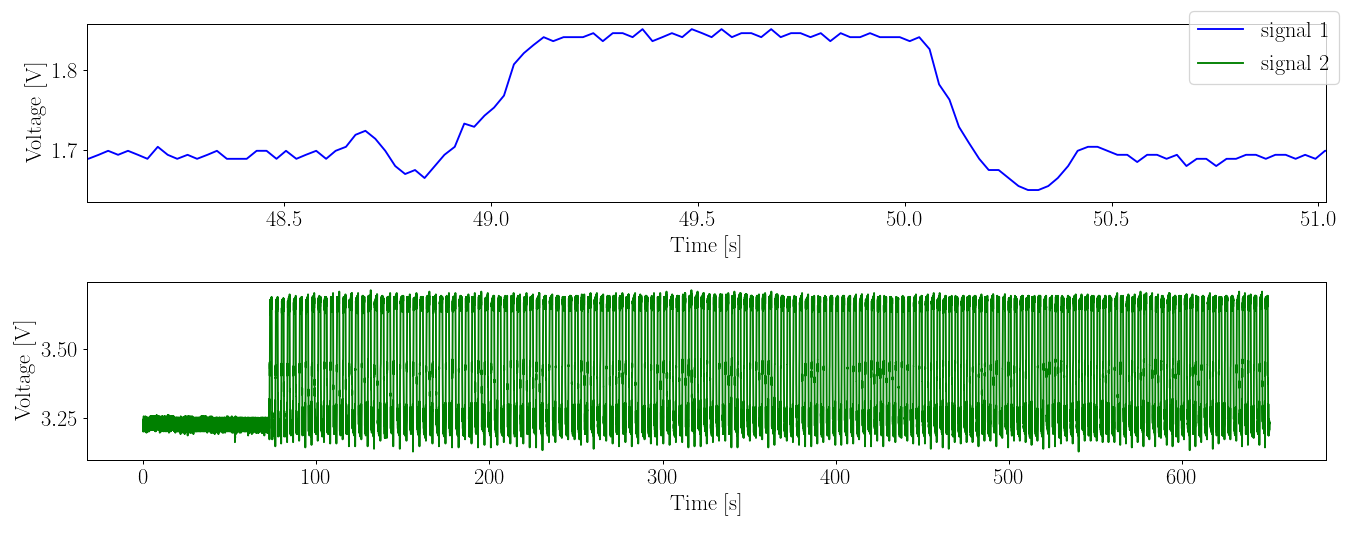

../Library\drop_detection_tools.py:55: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(loc='best')


In [71]:
#************************************
folder   = '../../../T-data/2-12/'
filename = 'B-ol5-aq5-pause10.csv'

fol_name = folder.rstrip('/').rsplit('/', 1)[1]

name     = fol_name + '_' + filename.rsplit('-',1)[0]
print(f'{name = }')
#************************************

raw = True 
sig1, sig2, t_raw = ddt.read_LV(folder, filename)

## Resample data

<ipython-input-4-2c55b89d88de>:22: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(loc='best')


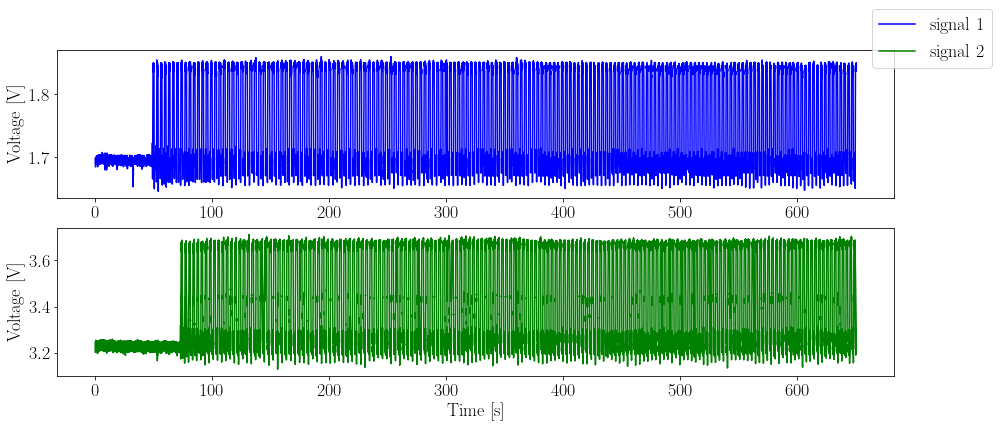

In [4]:
#******************************
dt = 0.01  # sampling time [s]
#******************************

# Resampling of the two signals
if raw:
    sig1, new_t = ddt.resample(sig1, t_raw, dt=dt)
    sig2, _     = ddt.resample(sig2, t_raw, dt=dt)
    t           = new_t
    raw         = False 
else:
    print('data already resampled')

    
# Signals plots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
axs[0].plot(t, sig1, color='blue', label= "signal 1")
axs[0].set_ylabel('Voltage [V]')
axs[1].plot(t, sig2, color='green', label= "signal 2")
axs[1].set_ylabel('Voltage [V]')
axs[1].set_xlabel('Time [s]')
fig.legend(loc='best')

## Fourier transform


In [5]:
min_freq  = 1       # lower cut-off frequency
max_freq  = 5000   # higher cut-off frequency

### Signal 1 

C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
../Library\drop_detection_tools.py:291: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  legend = fig.legend(['original signal','cropped signal'], loc='best')


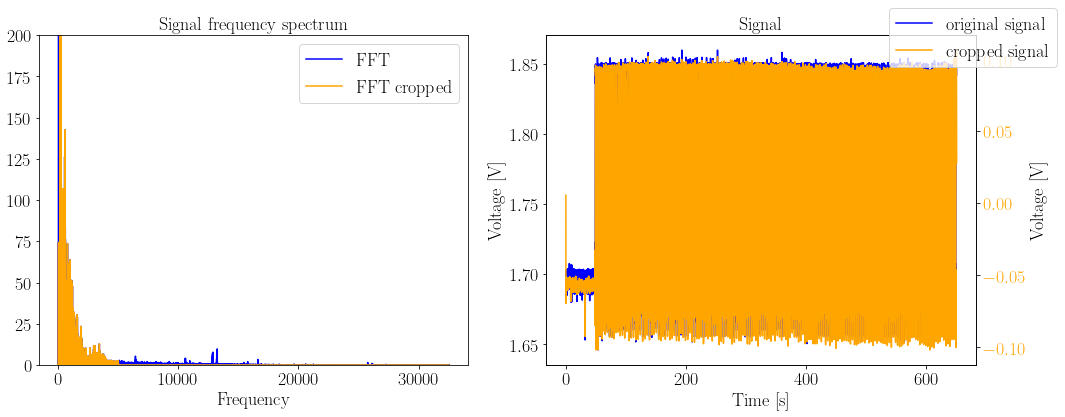

In [6]:
sig1_high = ddt.FFT_cropping(sig1, t, min_freq, max_freq)

### Signal 2 

C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
../Library\drop_detection_tools.py:291: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  legend = fig.legend(['original signal','cropped signal'], loc='best')


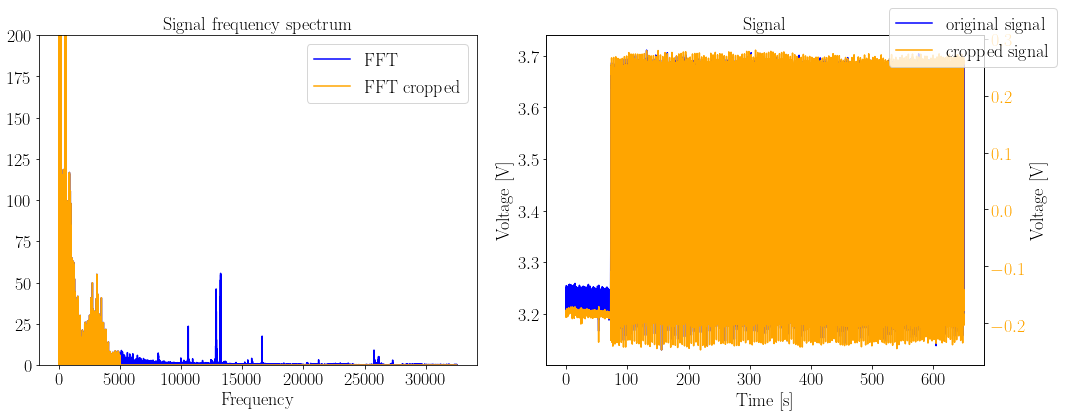

In [7]:
sig2_high = ddt.FFT_cropping(sig2, t, min_freq, max_freq)

## Signal Rectify

### Signal 1 

In [8]:
sig1_r = sig1_high
sig2_r = sig2_high

100%|██████████████████████████████████████████████████████████████████████████| 65068/65068 [00:11<00:00, 5668.22it/s]


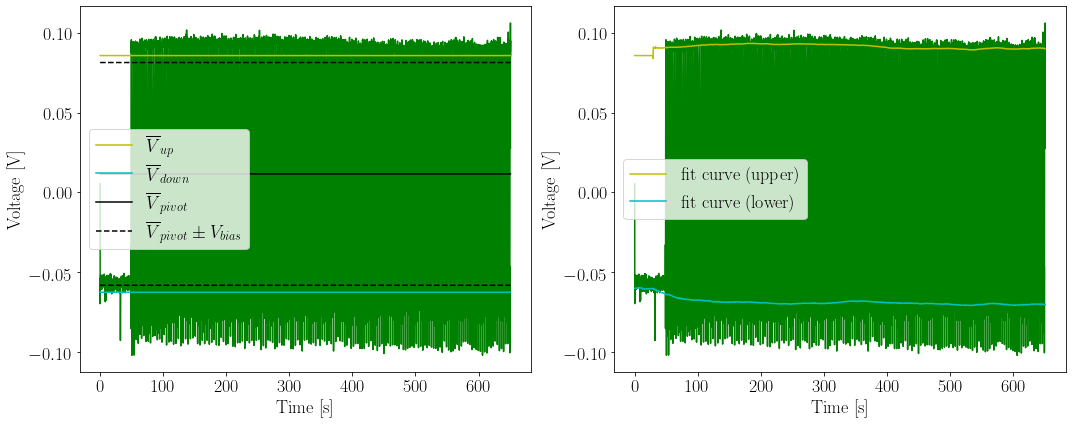

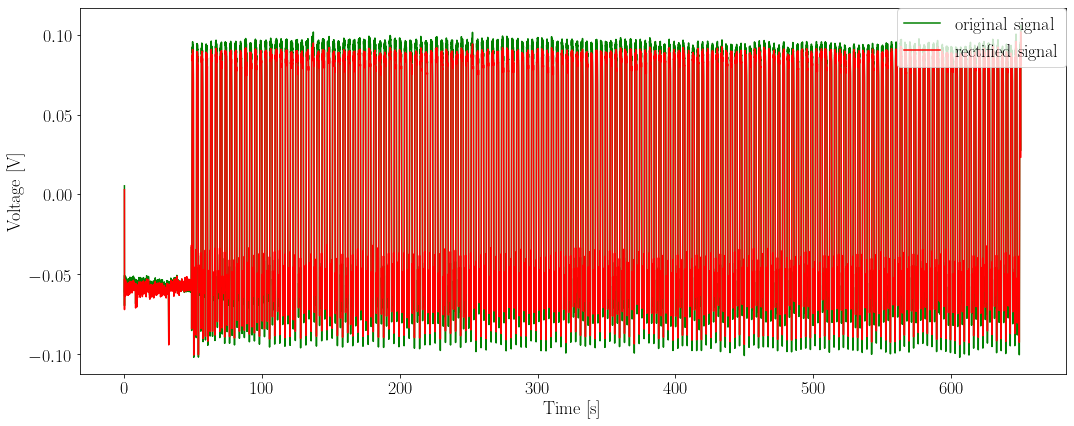

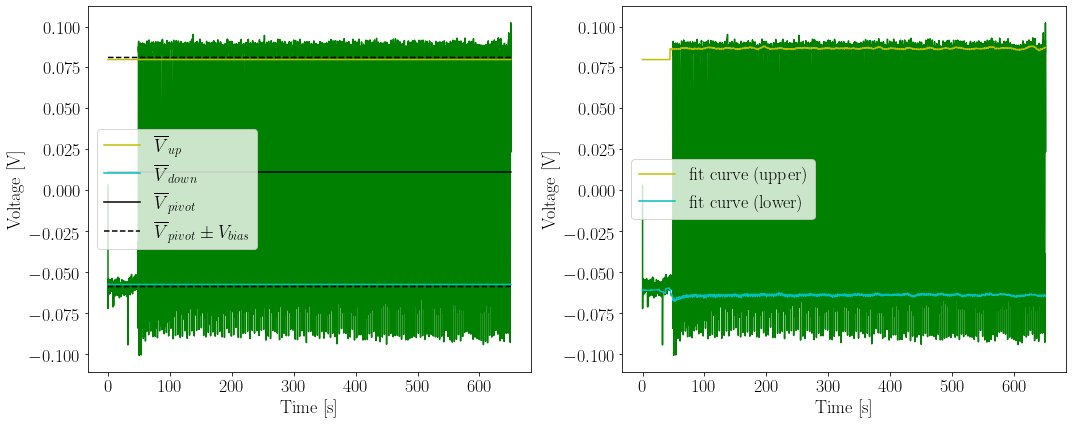

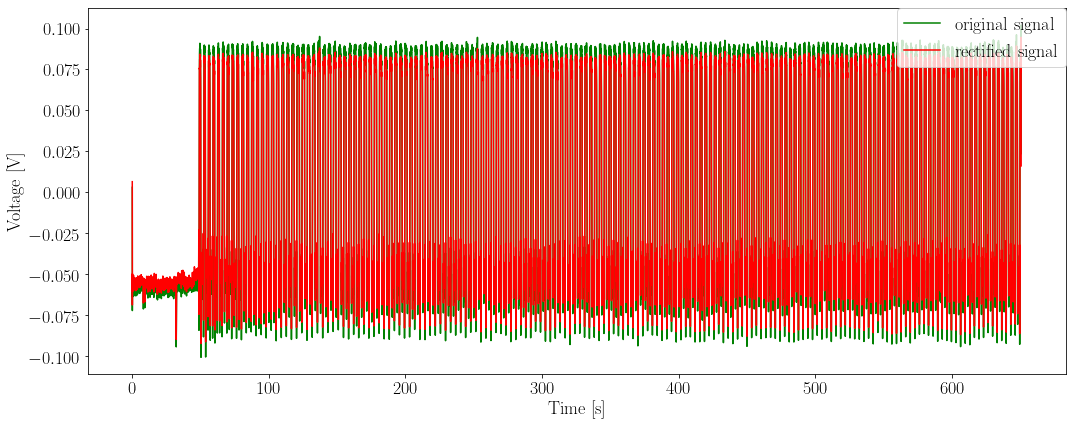

In [9]:
%matplotlib inline

fig, sig1_r = ddt.rectify_new(sig1_high, xrange=20, xdata=t, ignore_bias=0.07, manual_thr=-0.13)

fig, sig1_r = ddt.rectify_new(sig1_r, xrange=5, xdata=t, ignore_bias=0.07, manual_thr=-0.13)

### Signal 2

100%|██████████████████████████████████████████████████████████████████████████| 65068/65068 [00:10<00:00, 6500.16it/s]


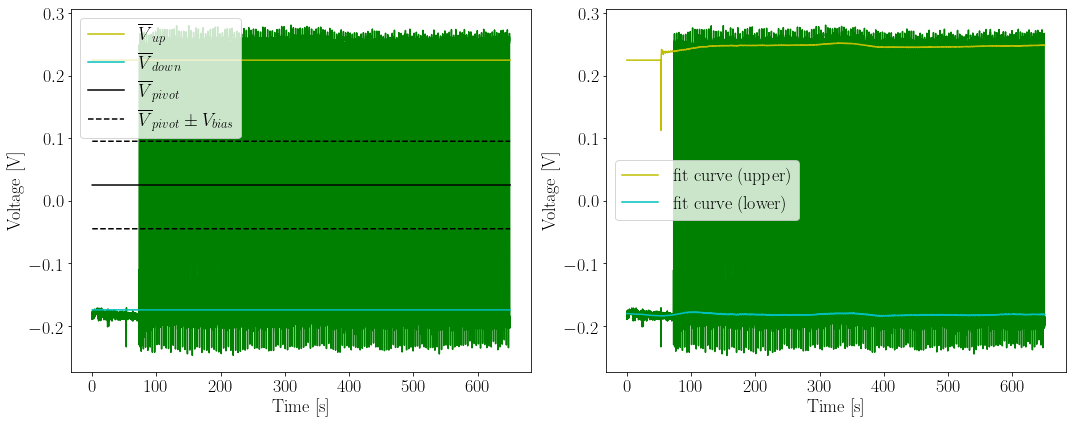

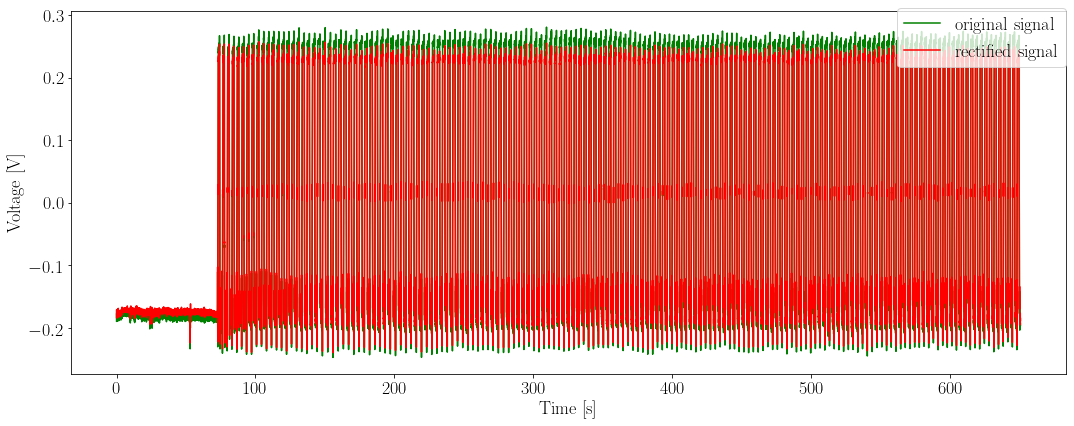

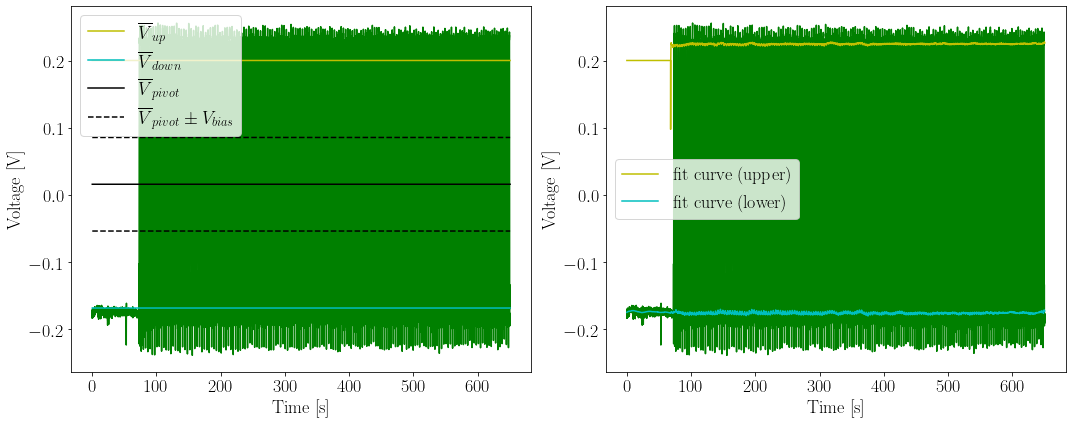

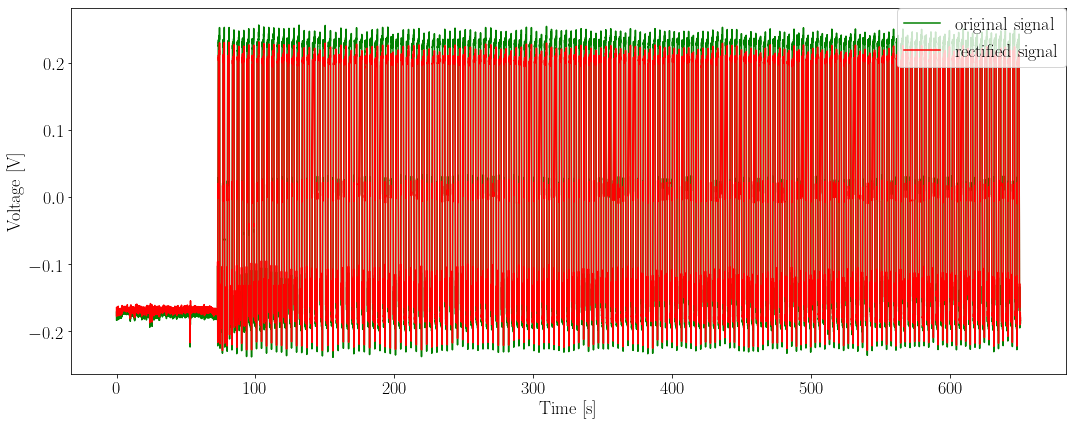

In [10]:
fig, sig2_r = ddt.rectify_new(sig2_high, xrange=20, xdata=t, ignore_bias=0.07, manual_thr=-0.32)

fig, sig2_r = ddt.rectify_new(sig2_r, xrange=5, xdata=t, ignore_bias=0.07, manual_thr=-0.32)

## Thresholds computing

### Signal 1

<IPython.core.display.Javascript object>


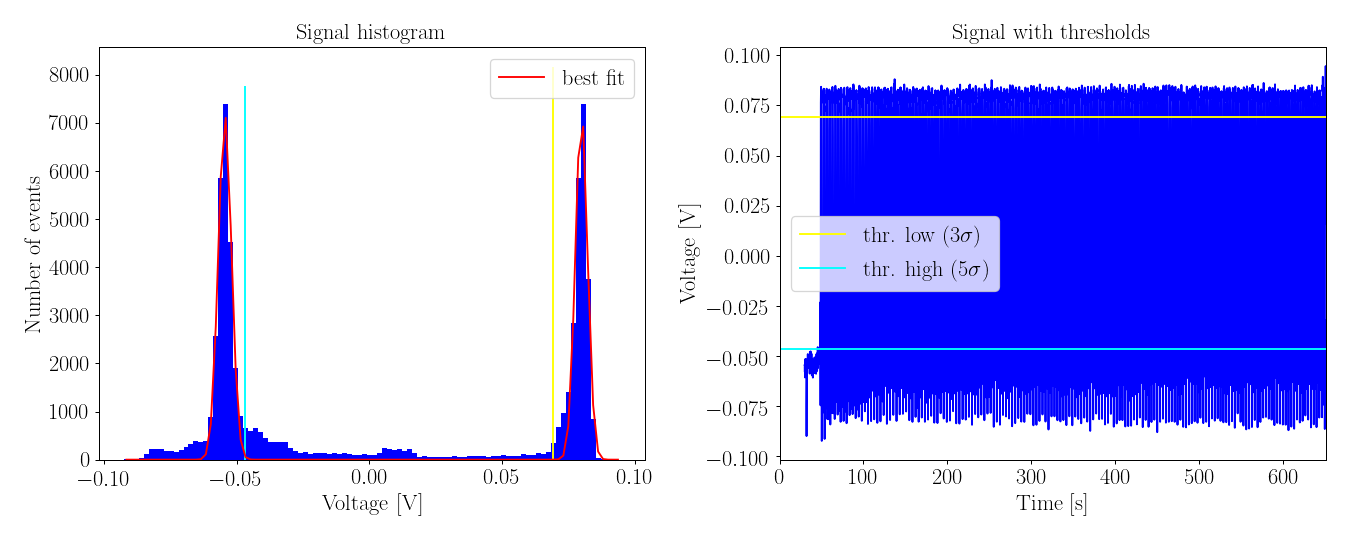

In [185]:
# %matplotlib notebook
# %matplotlib notebook
thr_low_1, thr_high_1, sigma_low_1, sigma_high_1 = ddt.thr_searcher(sig1_r[3000:], 100,
                                         high_sigmas=5, low_sigmas=3, Xdata=t[3000:],
                                         color='blue', xlabel='Time [s]', ylabel='Voltage [V]')

### Signal 2

<IPython.core.display.Javascript object>


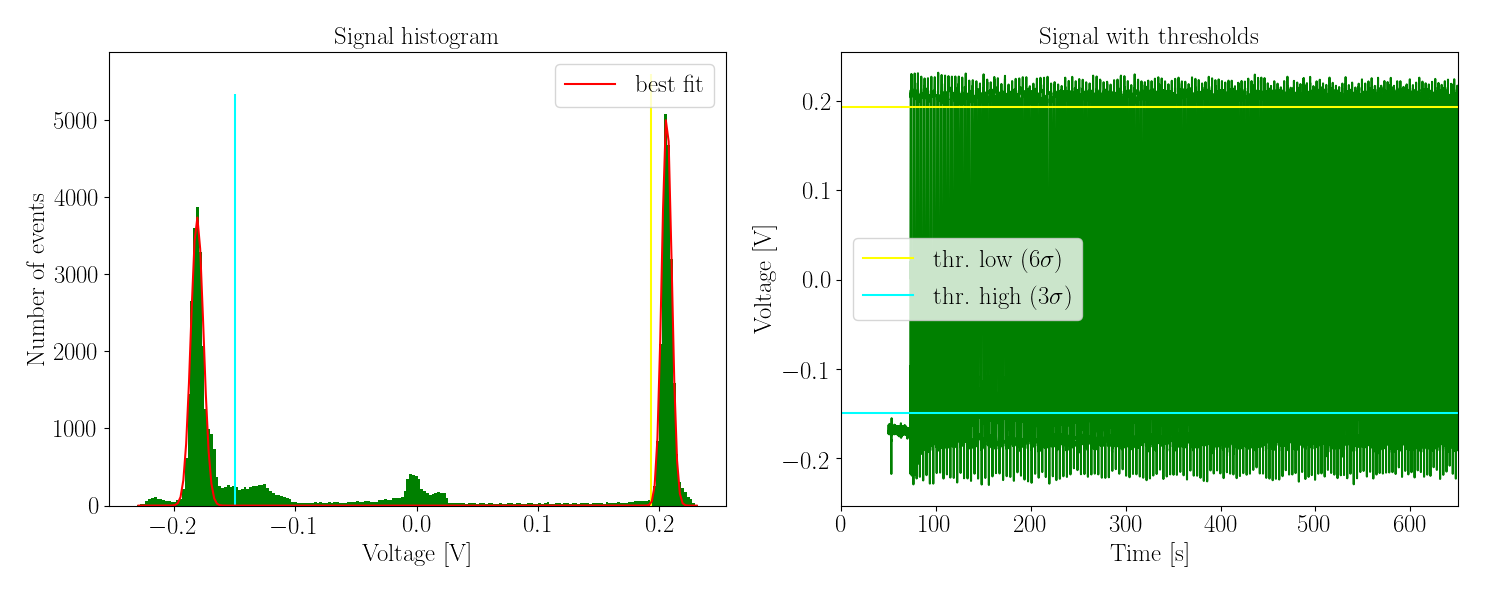

In [13]:
%matplotlib notebook
%matplotlib notebook
thr_low_2, thr_high_2, sigma_low_2, sigma_high_2 = ddt.thr_searcher(sig2_r[5000:], 200, low_sigmas=6, high_sigmas=3, Xdata=t[5000:],
                                         color='green', xlabel='Time [s]', ylabel='Voltage [V]')

## Drops detection

### Signal 1

In [151]:
reload(ddt)

<module 'drop_detection_tools' from '../Library\\drop_detection_tools.py'>

171 171
650.64 s: Couldn't find wide end, inserting a fake one
171 171


<IPython.core.display.Javascript object>


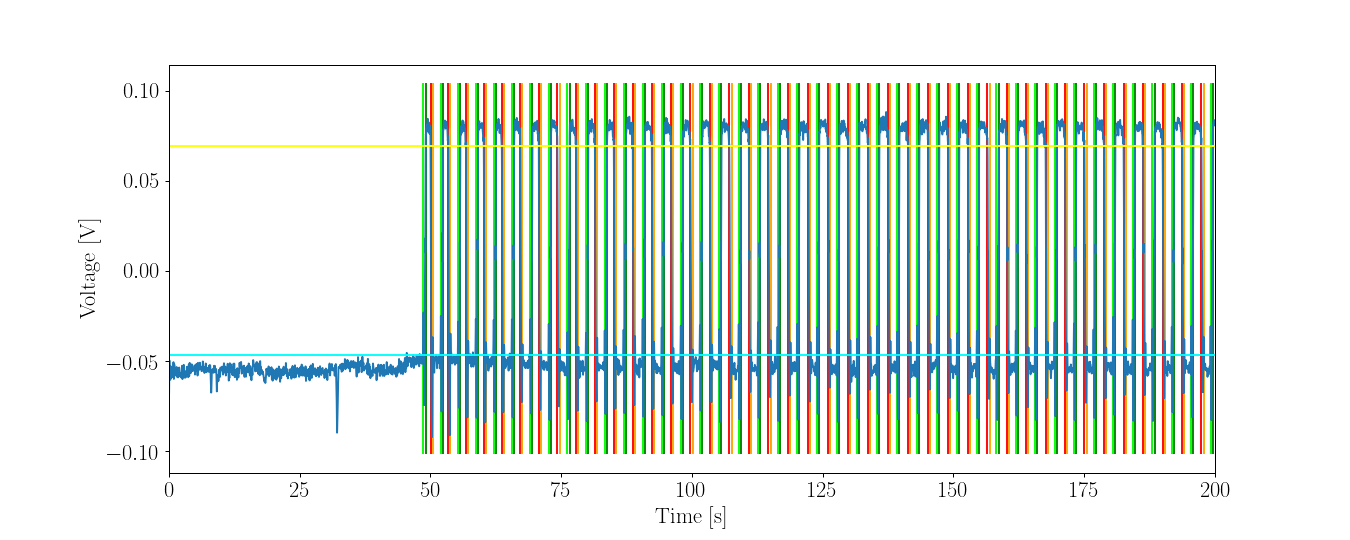

<IPython.core.display.Javascript object>


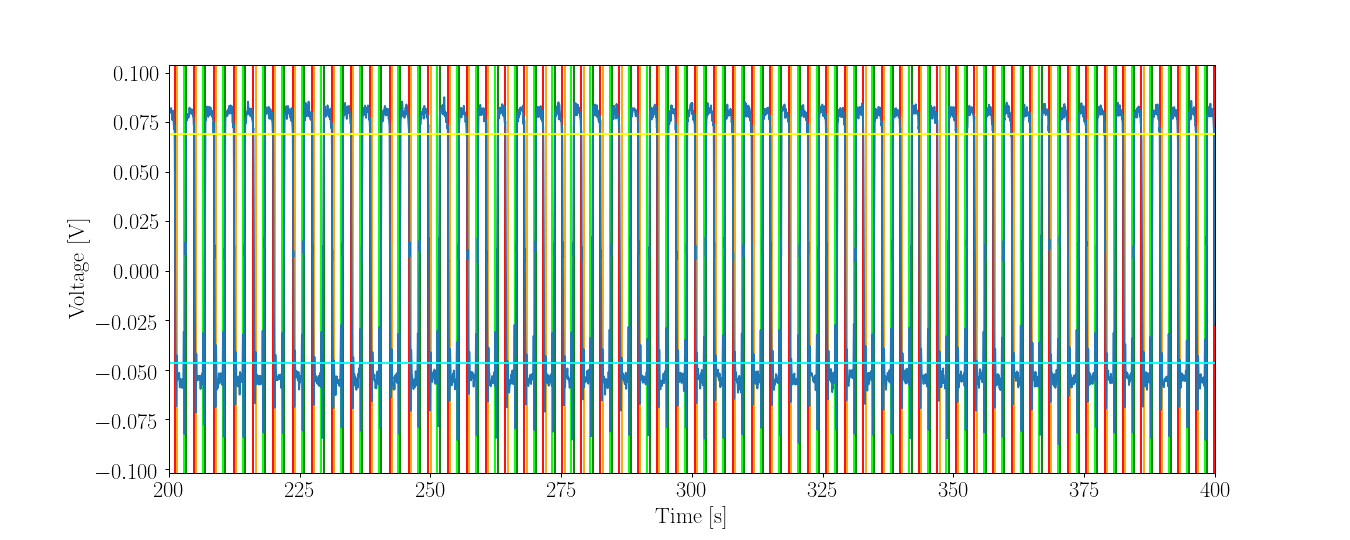

<IPython.core.display.Javascript object>


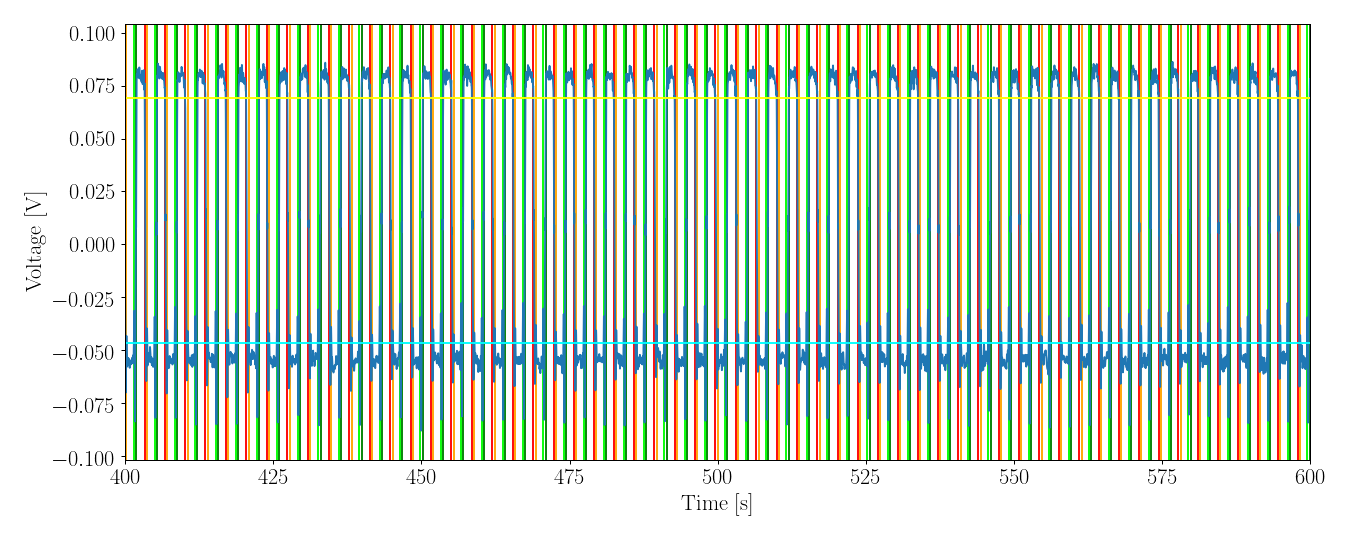

In [186]:
#****************************************
xrange = 200 # single plot x range [s]
#****************************************
reload(ddt)
%matplotlib notebook
%matplotlib notebook

returns = ddt.drop_det_new(t, sig1_r, thr_low_1, thr_high_1, backward_skip=1, forward_skip=1, return_indexes=True,
                       xrange=xrange, plot_switch=True, xlabel="Time [s]", ylabel="Voltage [V]")

narrow_start_1, narrow_end_1, wide_start_1, wide_end_1 = returns
#function modified to give output arrays in index form, not in seconds.

drop_edges_1 = np.array(list(zip(wide_start_1, narrow_start_1, narrow_end_1, wide_end_1)))


#### Manually correct the position of the edges

<IPython.core.display.Javascript object>


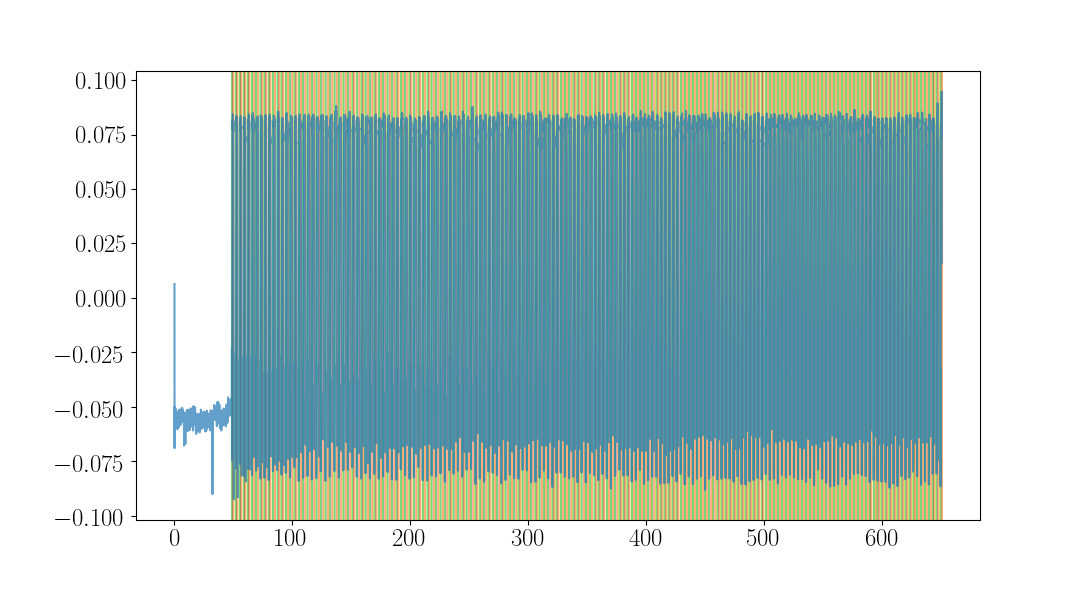

In [17]:
dec1 = ddt.DropEdgeCorrector(drop_edges_1)
dec1(t,sig1_r, figsize=(11,6))

In [92]:
drop_edges_1 = dec1.drop_edges

wide_start_1, narrow_start_1, narrow_end_1, wide_end_1 = drop_edges_1.T

### Signal 2

164 164
482.91 s: Missed previous wide end: trying to adjust
530.53 s: Missed previous wide end: trying to adjust
574.86 s: Missed previous wide end: trying to adjust
591.7 s: Missed previous wide end: trying to adjust
614.9300000000001 s: Missed previous wide end: trying to adjust
164 164


<IPython.core.display.Javascript object>


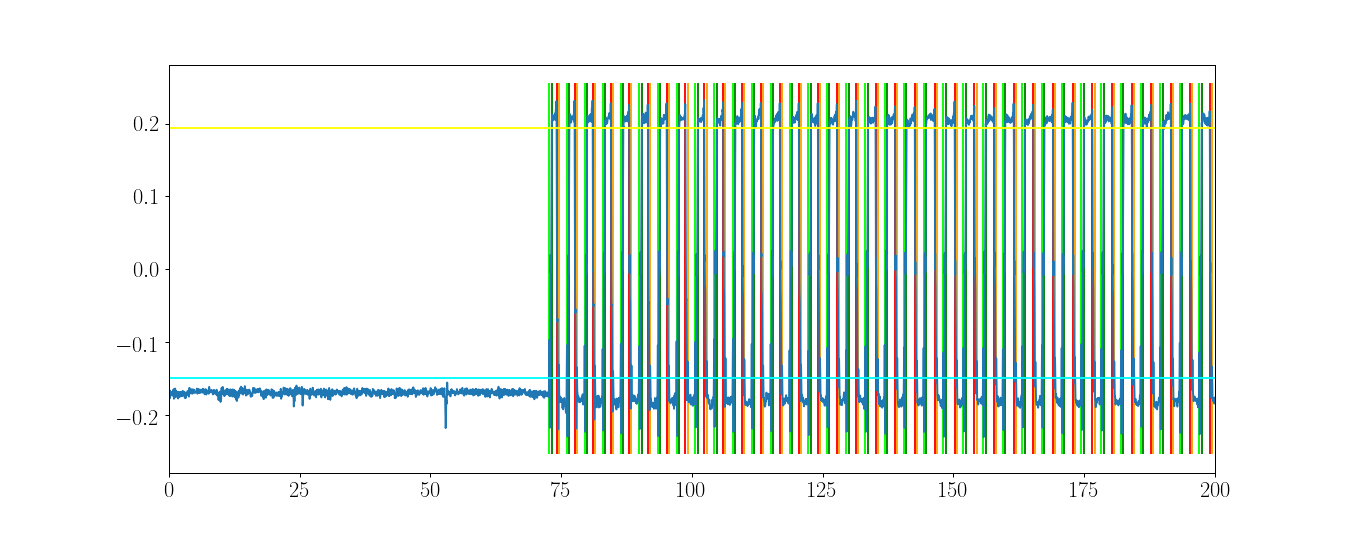

<IPython.core.display.Javascript object>


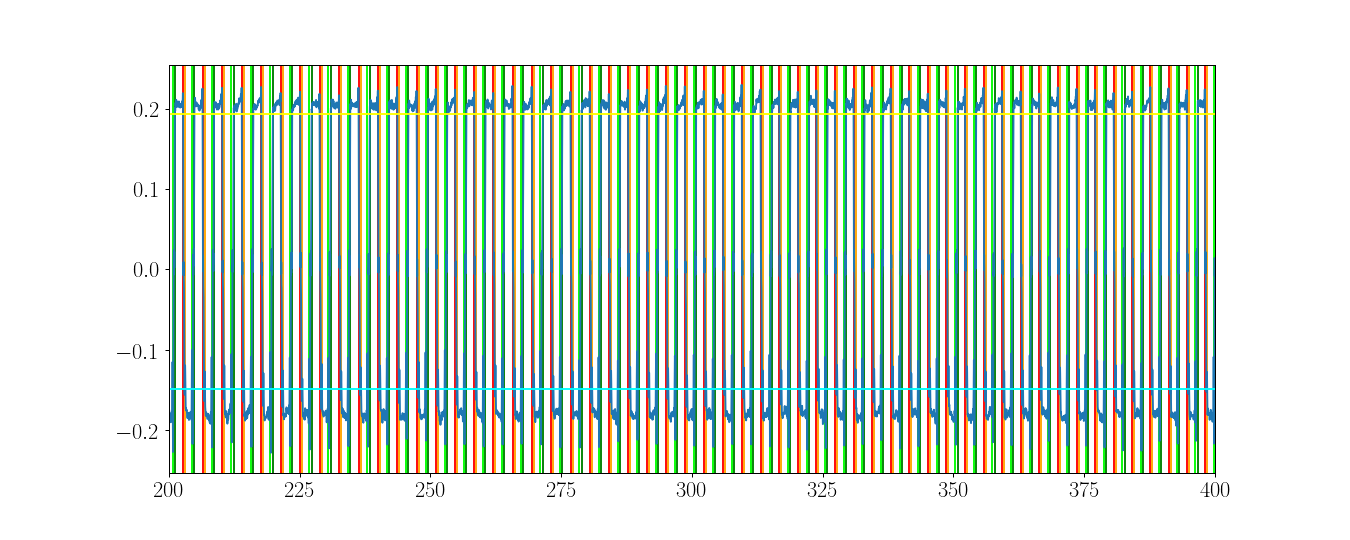

<IPython.core.display.Javascript object>


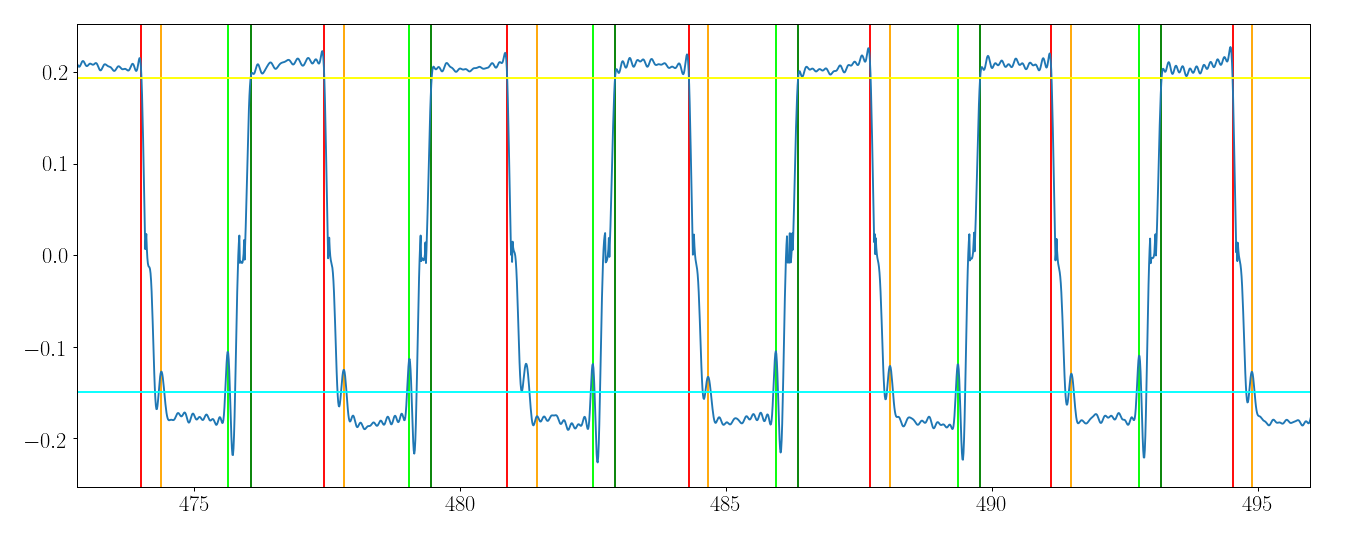

In [93]:
#****************************************
xrange = 200 # single plot x range [s]
#****************************************

%matplotlib notebook
returns = ddt.drop_det_new(t, sig2_r, thr_low_2, thr_high_2, backward_skip=1, forward_skip=1, return_indexes=True,
                       xrange=xrange, plot_switch=True)

narrow_start_2, narrow_end_2, wide_start_2, wide_end_2 = returns
#function modified to give output arrays in index form, not in seconds.

drop_edges_2 = np.array(list(zip(wide_start_2, narrow_start_2, narrow_end_2, wide_end_2)))


In [96]:
help(ddt.DropEdgeCorrector)

Help on class DropEdgeCorrector in module drop_detection_tools:

class DropEdgeCorrector(builtins.object)
 |  DropEdgeCorrector(drop_edges)
 |  
 |  Allows to interactively correct the position of the drop edges in index form.
 |  To do so call the object with arguments Xdata and Ydata and use the interactive plot that will appear.
 |  You NEED %matplotlib notebook.
 |  Once you have finished modifying the edges just use object.drop_edges to access the corrected drop_edges
 |  
 |  Controls:
 |      Right click on the right of an edge to select it.
 |      Press:
 |          f: to select the next edge
 |          b: to select the previous edge
 |          
 |          F: to select the next edge in the subset of the ones that have already been modified
 |          B: to select the previous edge in the subset of the ones that have already been modified
 |          
 |          a: to move the selected edge to the left by 1 data point
 |          A: to move the selected edge to the left by

<IPython.core.display.Javascript object>


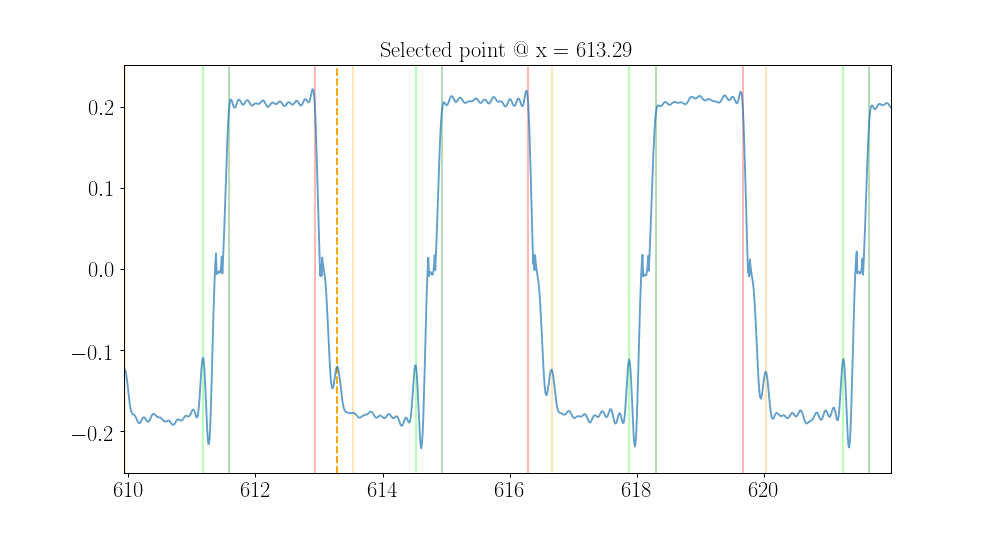

In [94]:
dec2 = ddt.DropEdgeCorrector(drop_edges_2)
dec2(t,sig2_r, figsize=(11,6))

In [97]:
drop_edges_2 = dec2.drop_edges

wide_start_2, narrow_start_2, narrow_end_2, wide_end_2 = drop_edges_2.T

## Add errors

<IPython.core.display.Javascript object>


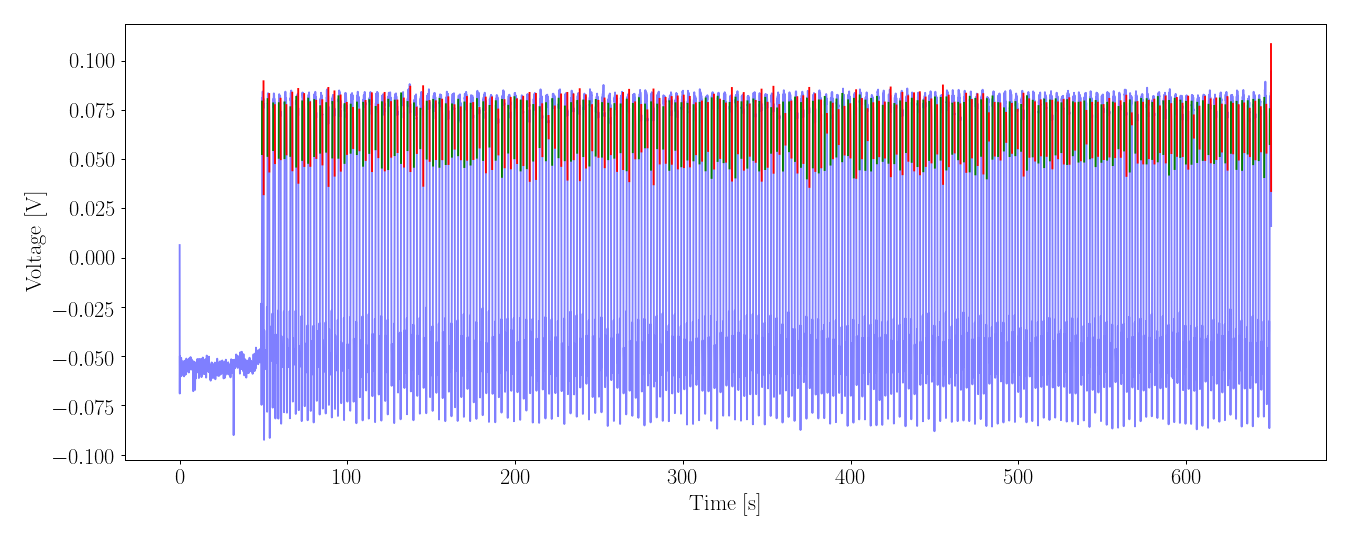

In [187]:
%matplotlib notebook
%matplotlib notebook
slope_start_1, slope_end_1=ddt.slopes(t,sig1_r, narrow_start_1, narrow_end_1, start_range=3, end_range = 5, xlabel="Time [s]", ylabel="Voltage [V]")

<IPython.core.display.Javascript object>


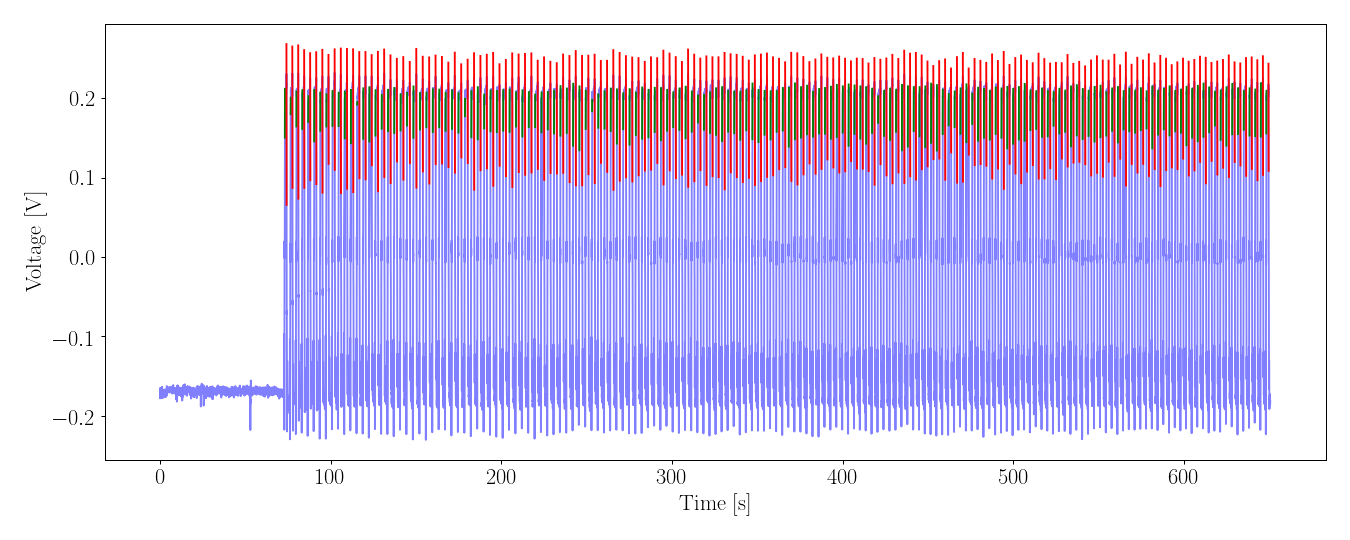

In [188]:
slope_start_2, slope_end_2=ddt.slopes(t,sig2_r, narrow_start_2, narrow_end_2, start_range=3, end_range = 5, xlabel="Time [s]", ylabel="Voltage [V]")

In [189]:
#slope errors for narrow_start and narrow_end
v_err_1 = sigma_high_1
err_slope_start_1 = v_err_1/slope_start_1
err_slope_end_1 = -v_err_1/slope_end_1

v_err_2 = sigma_high_2
err_slope_start_2 = v_err_2/slope_start_2
err_slope_end_2 = -v_err_2/slope_end_2


In [190]:
def res_error(time):
    a = t_raw[np.where(t_raw >= time)]
    if len(a)>1:
        return (a[1] - a[0])/np.sqrt(12)
    else: return 0
#     return a[1] - a[0]

### Make ufloats

In [191]:
#error resolution + error slope (seconds)
err_n_start_1=[]
err_n_end_1=[]
err_w_start_1=[]
err_w_end_1=[]
err_n_start_2=[]
err_n_end_2=[]
err_w_start_2=[]
err_w_end_2=[]

drop_edges_1 = [err_w_start_1, err_n_start_1, err_n_end_1, err_w_end_1]
drop_edges_2 = [err_w_start_2, err_n_start_2, err_n_end_2, err_w_end_2]

for drop_idx in range(len(narrow_start_1)):
    ens1 = (np.sqrt(res_error(t[narrow_start_1[drop_idx]])**2 + err_slope_start_1[drop_idx]**2))
    ene1 = (np.sqrt(res_error(t[narrow_end_1[drop_idx]])**2 + err_slope_end_1[drop_idx]**2))
    ews1 = (res_error(t[wide_start_1[drop_idx]]))
    ewe1 = (res_error(t[wide_end_1[drop_idx]]))
    
    err_n_start_1.append(unc.ufloat(t[narrow_start_1[drop_idx]],ens1))
    err_n_end_1.append(unc.ufloat(t[narrow_end_1[drop_idx]],ene1))
    err_w_start_1.append(unc.ufloat(t[wide_start_1[drop_idx]],ews1))
    err_w_end_1.append(unc.ufloat(t[wide_end_1[drop_idx]],ewe1))

for drop_idx in range(len(narrow_start_2)):
    ens2 = (np.sqrt(res_error(t[narrow_start_2[drop_idx]])**2 + err_slope_start_2[drop_idx]**2))
    ene2 = (np.sqrt(res_error(t[narrow_end_2[drop_idx]])**2 + err_slope_end_2[drop_idx]**2))
    ews2 = (res_error(t[wide_start_2[drop_idx]]))
    ewe2 = (res_error(t[wide_end_2[drop_idx]]))
    
    err_n_start_2.append(unc.ufloat(t[narrow_start_2[drop_idx]],ens2))
    err_n_end_2.append(unc.ufloat(t[narrow_end_2[drop_idx]],ene2))
    err_w_start_2.append(unc.ufloat(t[wide_start_2[drop_idx]],ews2))
    err_w_end_2.append(unc.ufloat(t[wide_end_2[drop_idx]],ewe2))
    

drop_edges_1 = [np.array(e) for e in drop_edges_1]
drop_edges_2 = [np.array(e) for e in drop_edges_2]

err_w_start_1, err_n_start_1, err_n_end_1, err_w_end_1 = drop_edges_1
err_w_start_2, err_n_start_2, err_n_end_2, err_w_end_2 = drop_edges_2

to_adjust = True

## Delay between detectors

In [24]:
# spannometric estimation of the time interval between the drops, knowing the pumps fluxes and capillary size

#********************************************************
radius  = 0.3  # capillary radius [mm]
sep     = 50   # spearation between the two sensors [mm]
flux_ol = 3    # oil flux   [uL/min] = [mm3/min]
flux_aq = 7    # water flux [uL/min] = [mm3/min]
#********************************************************

A  = np.pi*0.25*radius**2       # capillary area [mm2]
v  = (flux_ol + flux_aq)/A/60   # drops speed [mm/s]
dt = sep/v                      # time interval between two following drops [s]

print('v  = ', v,'\t[mm/s] \ndt = ', dt, '\t[s]')

v  =  2.3578510087688196 	[mm/s] 
dt =  21.205750411731106 	[s]


In [22]:
#this function calculates delay between sig1 and sig2 by spectra smoothing (delay_gauss) 
#and by simple spectra subtraction (delay_spectra)
    
def delay(sigma, delta, delta_delay, step_delay, start_time, stop_time, step_time, vec1, vec2, signal1, signal2,
          min_cut_idx=0, max_cut_idx=5000):   
    
    
    # Gaussian formula ---------------------------------------

    q = np.sqrt(2*np.pi)
    def gaus(x, mu, sigma):
        return np.exp(-(x - mu)**2/(2*sigma**2))/(sigma*q)

    
    # Gaussian smoothing functions ---------------------------

    # Signal 1
    @np.vectorize
    def sig1_smooth(t, sigma, delta):
        s = 0.
        for t_s in vec1:
            if (t - t_s)**2 < (delta*sigma)**2:
                s += gaus(t,t_s,sigma)
            if t_s - t > (delta+1)*sigma:
                break
        return s
    
    # Signal 2
    @np.vectorize
    def sig2_smooth(t, sigma, delta):
        s = 0.
        for t_s in vec2:
            if (t - t_s)**2 < (delta*sigma)**2:
                s += gaus(t,t_s,sigma)
            if t_s - t > (delta+1)*sigma:
                break
        return s


    # Delay computing ::::::::::::::::::::::::::::::::::::::::::::
    
    start_delay = dt - delta_delay                                # initial evaluated delay [s]
    stop_delay  = dt + delta_delay                                # final evaluated delay [s]
    time_delays = np.arange(start_delay, stop_delay, step_delay)  # vector of evaluated delays [s]
    ts          = np.arange(start_time,  stop_time,  step_time)   # vector of scanned times [s]
    msqs        = []                                              # stdev between sig.1 and sig.2 delayed 

    
    # Computing delay_gauss --------------------------------------
    
    for time_delay in tqdm(time_delays):

        sig1_t = sig1_smooth(ts, sigma, delta)
        sig2_t = sig2_smooth(ts + time_delay, sigma, delta)
        msqs.append(np.mean((sig2_t - sig1_t)**2))

    msqs=np.array(msqs)
    delay_gauss=time_delays[msqs==min(msqs)]
    
    
    # Delay with spectra-subtraction -----------------------------
    
    delay_idxs = np.arange(int(start_delay*100), int(stop_delay*100))
    msqs1 = []

    for idx in delay_idxs:
            #sig1_cut = sig1_high[:len(sig2_high) - idx][start_time*100:stop_time*100]
            #sig2_cut = sig2_high[idx:][start_time*100:stop_time*100]
            sig1_cut = signal1[:len(signal2) - idx][min_cut_idx:max_cut_idx]
            sig2_cut = signal2[idx:][min_cut_idx:max_cut_idx]
            msqs1.append(np.mean((sig1_cut - sig2_cut)**2))
    msqs1=np.array(msqs1)
    delay_spectra=t[delay_idxs[[msqs1==min(msqs1)]]] 
   

    # Plots ------------------------------------------------------
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))    
    ax[0].set_title('Delay spectrum from gaussian broadening')
    ax[0].set_xlabel("delay [s]")
    ax[0].set_ylabel("msqs")
    ax[0].plot(time_delays,msqs)
    ax[1].set_title('Delay spectrum from signal subtraction')
    ax[1].set_xlabel("Delay [s]")
    ax[1].set_ylabel("msqs")
    ax[1].set_xlim(*ax[0].get_xlim())
    ax[1].plot(t[delay_idxs],msqs1)
    fig.tight_layout()
    
    #define the number of initial drops to be neglected in sig2 
    neglected_drops_2 = vec2[vec2<delay_spectra]
    d2 = len(neglected_drops_2)    
          
    return delay_gauss, delay_spectra, d2

100%|██████████| 400/400 [00:12<00:00, 31.29it/s]
<ipython-input-22-b2ea4181de10>:73: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  delay_spectra=t[delay_idxs[[msqs1==min(msqs1)]]]


<IPython.core.display.Javascript object>


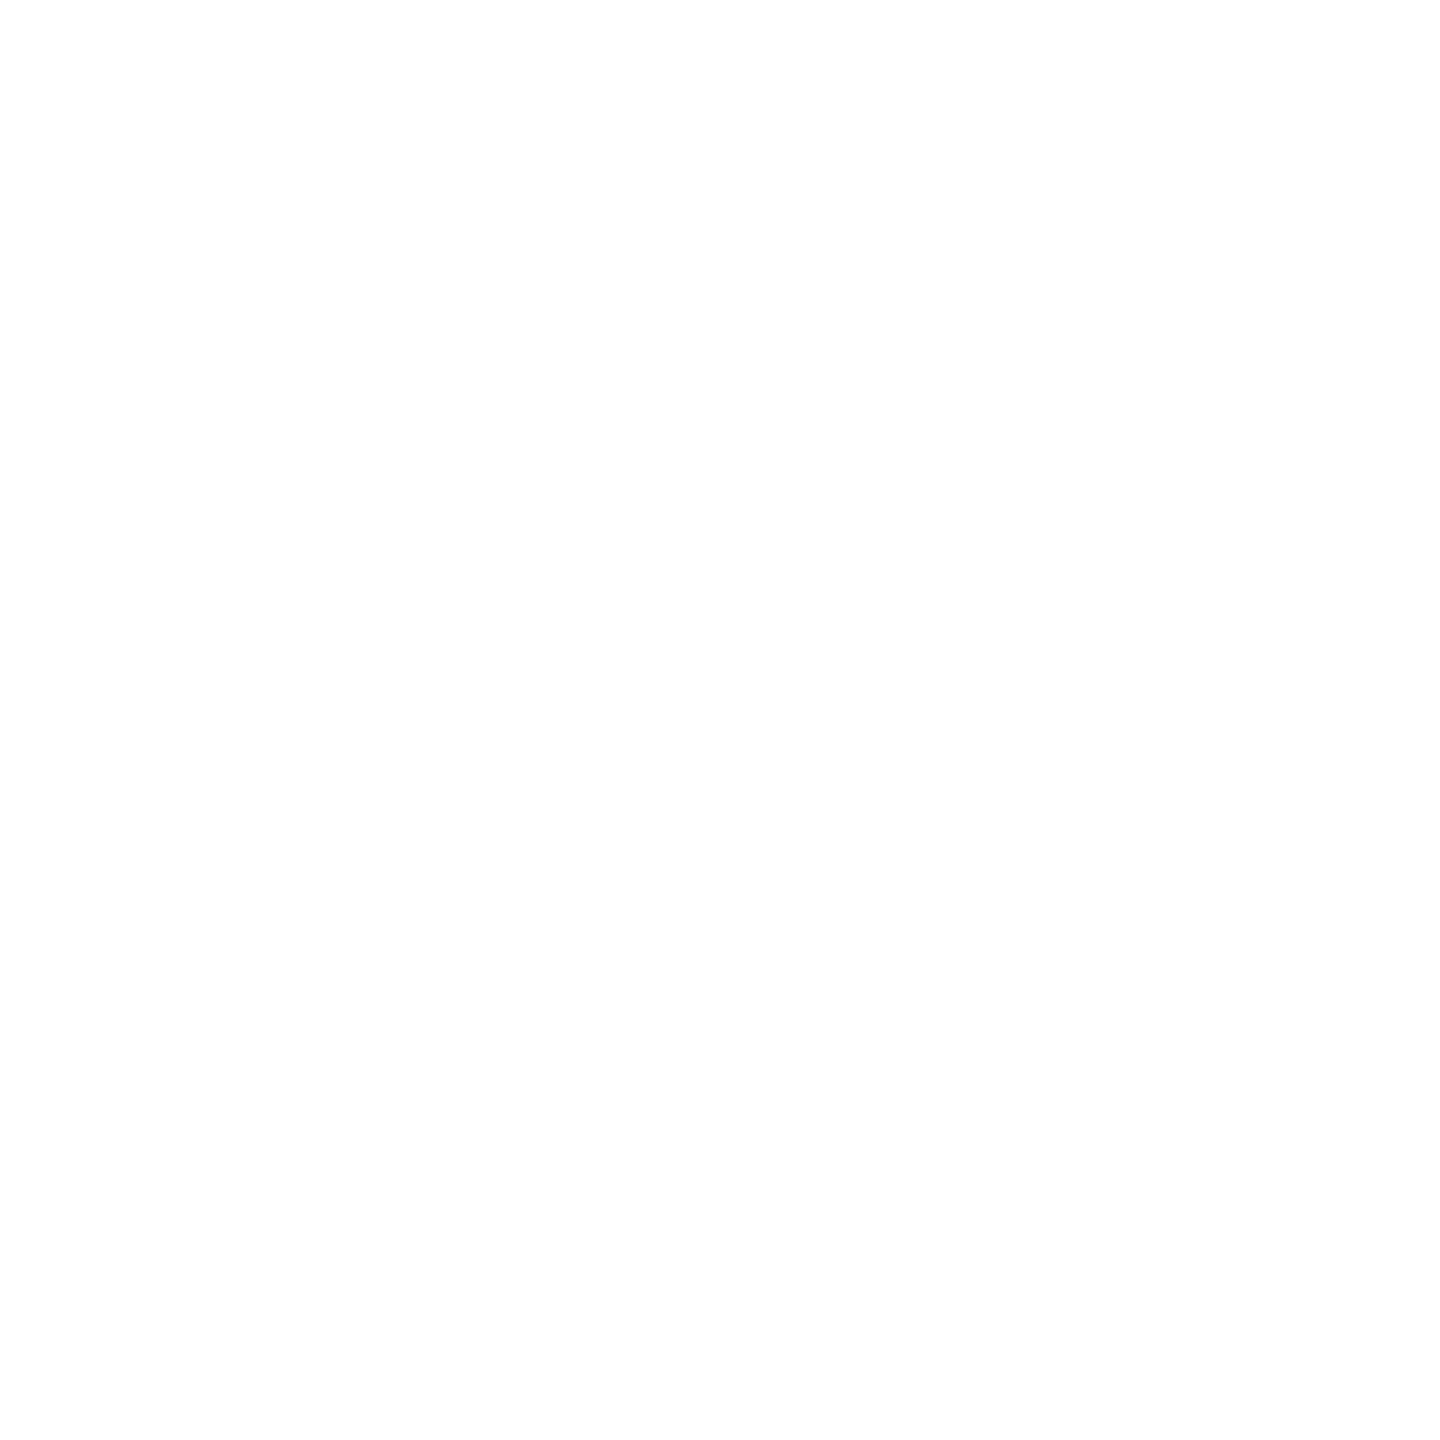

(array([15.50575041]), array([17.98]), 2)

In [23]:
#*********************************************************************************************
# Signal gaussian smoothing
sigma       = 0.01   # stdev
delta       = 2      # range = delta*stdev
# Delay
delta_delay = 10      # range of evaluated delays = [dt - delta_delay ; dt + delta_delay] [s]
step_delay  = 0.05   # step of evaluated delays [s]
# Time
start_time  = 30     # scanning signal starting time [s]
stop_time   = 45     # scanning signal stopping time [s]
step_time   = 0.005  # scanning signal step time [s]

vec1 = np.array([d.n for d in err_w_start_1])
vec2 = np.array([d.n for d in err_w_start_2])

signal1 = sig1_r
signal2 = sig2_r
#*********************************************************************************************

delay_gauss, delay_spectra, d2 = delay(sigma, delta, delta_delay, step_delay, start_time, stop_time, step_time,
                                       vec1, vec2, signal1, signal2,
                                       min_cut_idx=3000, max_cut_idx = 4500)

delay_gauss, delay_spectra, d2

### Manually check the delay

In [25]:
def align(delay):
    
    delay_idx = int(delay*100)
    
    fig, ax1 = plt.subplots(figsize=(9,6))
    
    ax1.plot(t, sig1_r, color='blue', alpha=0.3)
    
    ax2 = ax1.twinx()
    
    ax2.plot(t[:-delay_idx], sig2_r[delay_idx:], color='red', alpha=0.3)
    

def align_space(delay):
    delay_idx = int(delay*100)
    
    fig, ax1 = plt.subplots(figsize=(9,6))
    
    ax1.plot(t*50/delay, sig1_r, color='blue', alpha=0.3)
    
    ax2 = ax1.twinx()
    
    ax2.plot(t[:-delay_idx]*50/delay, sig2_r[delay_idx:], color='red', alpha=0.3)
    
    ax1.set_xlabel('position [mm]')

In [25]:
delay_gauss, delay_spectra, d2

(array([15.50575041]), array([17.98]), 2)

<IPython.core.display.Javascript object>


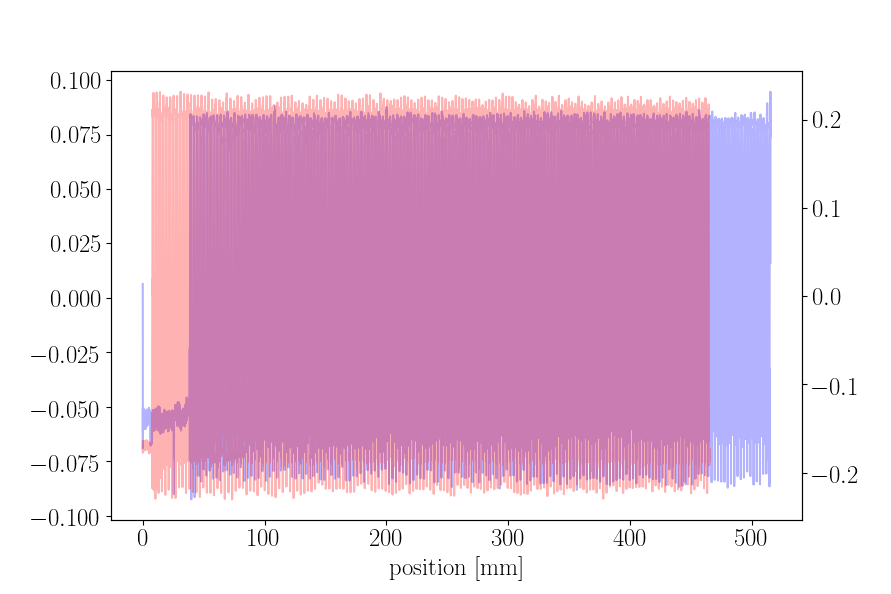

In [26]:
%matplotlib notebook
%matplotlib notebook

align_space(63.15)

## Adjust drops according to delay

In [135]:
#decide whether to use calculated d2 or to set it by hand
#d2 = 2
def adjust_drops(d1,d2, drop_edges_1, drop_edges_2):
    
    drop_edges_1 = [d[d1:] for d in drop_edges_1]
    drop_edges_2 = [d[d1 + d2:] for d in drop_edges_2]
    
    len2 = len(drop_edges_2[0])
    drop_edges_1 = [d[:len2] for d in drop_edges_1]
    
    return drop_edges_1, drop_edges_2

In [192]:
#THIS FUNCTION MODIFIES drop_start and drop_end s arrays

d1 = 0          #d1>0 to discard some initial drops that are present in both signals
#d2 = 0
if to_adjust:
    drop_edges_1,drop_edges_2 = adjust_drops(d1,d2, drop_edges_1, drop_edges_2)

    err_w_start_1, err_n_start_1, err_n_end_1, err_w_end_1 = drop_edges_1
    err_w_start_2, err_n_start_2, err_n_end_2, err_w_end_2 = drop_edges_2
    
    to_adjust = False

# PLOTTING

### functions for plotting and file for saving parameters

In [137]:
def double_histo_plot(bins, v_1, v_2, title, xlabel, ylabel):
    
    #reload(uplt)
    fig = plt.figure(figsize=(10,5))
    gs = GridSpec(3,5)

    ax_joint = fig.add_subplot(gs[:,0:3])
    ax_marg_y_1 = fig.add_subplot(gs[:,3])
    ax_marg_y_2 = fig.add_subplot(gs[:,4])

    uplt.plot(v_1, ax = ax_joint, label='sig1')
    uplt.plot(v_2, ax = ax_joint, color='green', label='sig2')

    k1=uplt.ExtendedKDE(v_1) 
    ylim=ax_joint.get_ylim()
    x1,f1 = k1.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_1, switch_xy=True)

    k2=uplt.ExtendedKDE(v_2) 
    ylim=ax_joint.get_ylim()
    x2,f2 = k2.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_2, switch_xy=True, color='green')

    #Turn off tick labels on marginals
    plt.setp(ax_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y_2.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel(xlabel)
    ax_joint.set_ylabel(ylabel)

    ax_joint.legend(loc='best')
    plt.title(title,loc='right', pad=15)

    #kde fit

    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
    out1 = mod1.fit(f1, pars1, x=x1)
    ax_marg_y_1.plot(out1.best_fit, x1, 'r-', label='best fit')

    mod2 = GaussianModel(prefix='g2_')
    pars2 = mod2.guess(f2, x=x2)
    out2 = mod2.fit(f2, pars2, x=x2)
    ax_marg_y_2.plot(out2.best_fit, x2, 'r-', label='best fit')
       
    c_1 = unc.ufloat(out1.params['g1_center'].value, out1.params['g1_center'].stderr)
    sigma_1 = unc.ufloat(out1.params['g1_sigma'].value, out1.params['g1_sigma'].stderr)
    c_2 = unc.ufloat(out2.params['g2_center'].value, out2.params['g2_center'].stderr)
    sigma_2 = unc.ufloat(out2.params['g2_sigma'].value, out2.params['g2_sigma'].stderr)

    fig.tight_layout()
    plt.show()
    
    return fig, c_1, sigma_1, c_2, sigma_2

In [138]:
def dt_vel(bins,dt_mid,v_mid):
    
    fig = plt.figure(figsize=(10,7.5))

    gs = GridSpec(7,4)
    #first plot
    ax_joint = fig.add_subplot(gs[:3,0:3])
    ax_marg_y = fig.add_subplot(gs[:3,3])

    uplt.plot(dt_mid, ax = ax_joint, label='time interval')  
    
    k1=uplt.ExtendedKDE(dt_mid) 
    ylim=ax_joint.get_ylim()
    x1,f1 = k1.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y, switch_xy=True)

    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('detectors time interval [s]')

    plt.title('Temporal delay of drops in the detectors and drop velocity',loc='right', pad=15)

    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    #second plot
    ax1_joint = fig.add_subplot(gs[4:,0:3])
    ax1_marg_y = fig.add_subplot(gs[4:,3])

    uplt.plot(0.5*(np.mean(drop_edges_1,0)+np.mean(drop_edges_2,0)),v_mid, ax=ax1_joint, label='velocity', color='green')
    k2=uplt.ExtendedKDE(v_mid) 
    ylim=ax1_joint.get_ylim()
    x2,f2 = k2.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax1_marg_y, switch_xy=True, color='green')


    ax1_joint.set_xlabel('time (drop equidistant from detectors) [s]')
    ax1_joint.set_ylabel('drops velocity [mm/s]')
    
   
    plt.setp(ax1_marg_y.get_yticklabels(), visible=False)
    
    #Turn off tick labels on marginals
    plt.setp(ax1_marg_y.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

       
    fig.tight_layout()
    plt.show()

    
    return fig

In [139]:
a='parameters'
with open(f'{plot_dir}/{name}_{a}.csv', mode='w', newline ='') as file:
    writer = csv.writer(file, delimiter='	', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    s = ['file containing parameters from fit: center_1, sigma_1, center_2, sigma_2']
    writer.writerow(s)

### temporal distance

<IPython.core.display.Javascript object>


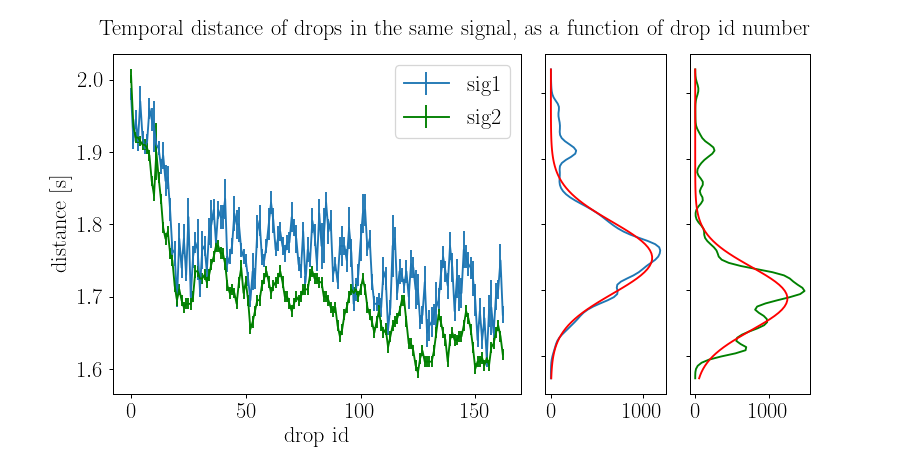

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.70it/s]
<ipython-input-137-c34510fce8cc>:50: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [142]:
title = 'Temporal distance of drops in the same signal, as a function of drop id number'
xlabel = 'drop id'
ylabel = 'distance [s]'
bins    = 100

t_dist_1 =  (drop_edges_1[0][1:]-drop_edges_1[2][:-1]+drop_edges_1[1][1:]-drop_edges_1[3][:-1])*0.5
t_dist_2 =  (drop_edges_2[0][1:]-drop_edges_2[2][:-1]+drop_edges_2[1][1:]-drop_edges_2[3][:-1])*0.5

f1, t_d_fit_1, sigma_t_d_fit_1, t_d_fit_2, sigma_t_d_fit_2 = double_histo_plot(bins, v_1=t_dist_1, v_2=t_dist_2, 
                                                                    title=title, xlabel=xlabel, ylabel=ylabel)

subname = 'time_dist'
f1.savefig(f'{plot_dir}/{name}_{subname}.png')
r = ['temporal distance [s]', t_d_fit_1.n, t_d_fit_1.s, sigma_t_d_fit_1.n, sigma_t_d_fit_1.s,
      t_d_fit_2.n, t_d_fit_2.s, sigma_t_d_fit_2.n, sigma_t_d_fit_2.s ]
with open(f'{plot_dir}/{name}_{a}.csv', mode='a', newline ='') as file:
    writer = csv.writer(file, delimiter='	', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(r)

### temporal size

<IPython.core.display.Javascript object>


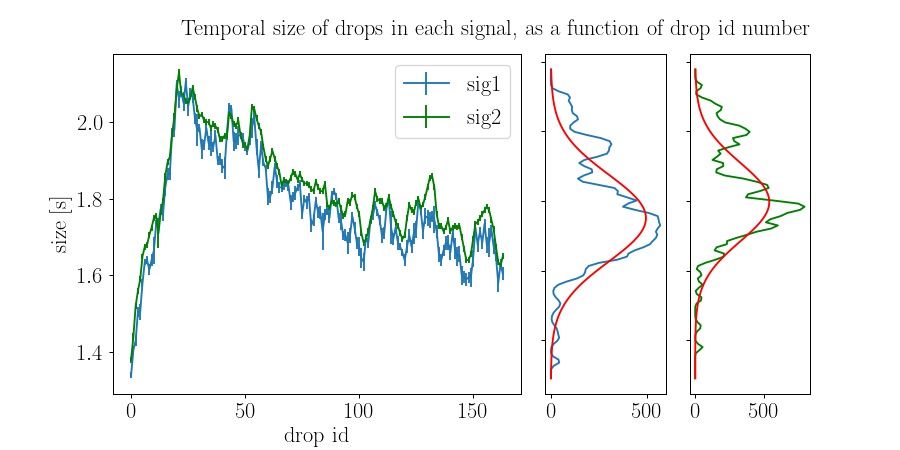

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.71it/s]
<ipython-input-137-c34510fce8cc>:50: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [143]:
title = 'Temporal size of drops in each signal, as a function of drop id number'
xlabel = 'drop id'
ylabel = 'size [s]'
bins=100

t_size_1 =  (drop_edges_1[2]-drop_edges_1[0]+drop_edges_1[3]-drop_edges_1[1])*0.5
t_size_2 =  (drop_edges_2[2]-drop_edges_2[0]+drop_edges_2[3]-drop_edges_2[1])*0.5

f2, t_s_fit_1, sigma_t_s_fit_1, t_s_fit_2, sigma_t_s_fit_2 = double_histo_plot(bins, v_1=t_size_1, v_2=t_size_2, 
                                                                    title=title, xlabel=xlabel, ylabel=ylabel)

subname = 'time_size'
f2.savefig(f'{plot_dir}/{name}_{subname}.png')

r = ['temporal size [s]', t_s_fit_1.n, t_s_fit_1.s, sigma_t_s_fit_1.n, sigma_t_s_fit_1.s,
      t_s_fit_2.n, t_s_fit_2.s, sigma_t_s_fit_2.n, sigma_t_s_fit_2.s ]
with open(f'{plot_dir}/{name}_{a}.csv', mode='a', newline ='') as file:
    writer = csv.writer(file, delimiter='	', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(r)

### temporal period

<IPython.core.display.Javascript object>


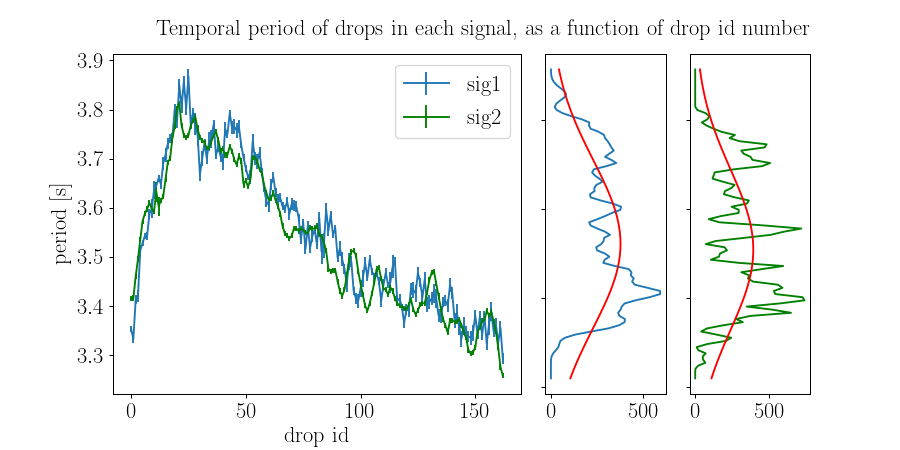

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.76it/s]
<ipython-input-137-c34510fce8cc>:50: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [144]:
title = 'Temporal period of drops in each signal, as a function of drop id number'
xlabel = 'drop id'
ylabel = 'period [s]'
bins=100

t_period_1 =  (drop_edges_1[0][1:]-drop_edges_1[0][:-1])*0.25
t_period_2 =  (drop_edges_2[0][1:]-drop_edges_2[0][:-1])*0.25
for i in range(1,4):
    t_period_1 +=  (drop_edges_1[i][1:]-drop_edges_1[i][:-1])*0.25
    t_period_2 +=  (drop_edges_2[i][1:]-drop_edges_2[i][:-1])*0.25

f3, t_p_fit_1, sigma_t_p_fit_1, t_p_fit_2, sigma_t_p_fit_2 = double_histo_plot(bins, v_1=t_period_1, v_2=t_period_2, 
                                                                    title=title, xlabel=xlabel, ylabel=ylabel)

subname = 'time_period'
f3.savefig(f'{plot_dir}/{name}_{subname}.png')

r = ['temporal period [s]', t_p_fit_1.n, t_p_fit_1.s, sigma_t_p_fit_1.n, sigma_t_p_fit_1.s,
      t_p_fit_2.n, t_p_fit_2.s, sigma_t_p_fit_2.n, sigma_t_p_fit_2.s ]
with open(f'{plot_dir}/{name}_{a}.csv', mode='a', newline ='') as file:
    writer = csv.writer(file, delimiter='	', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(r)

### velocity

<IPython.core.display.Javascript object>


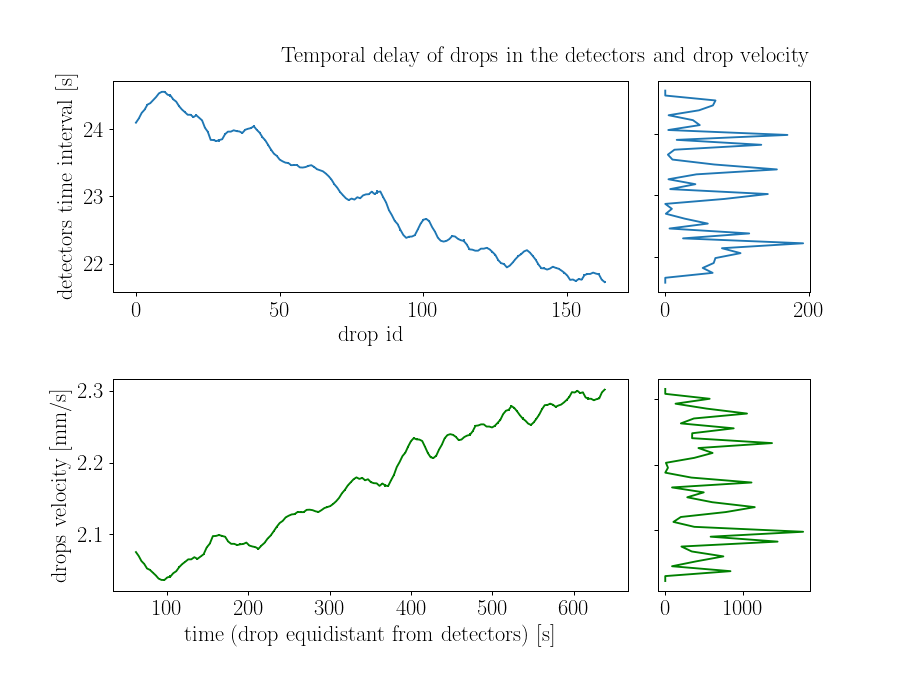

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.45it/s]
<ipython-input-138-74c9a38e24bd>:44: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [145]:
bins=40

dt_mid = (drop_edges_2[0]-drop_edges_1[0])*0.25
for i in range(1,4):
    dt_mid += (drop_edges_2[i]-drop_edges_1[i])*0.25    
v_mid = 50/dt_mid

f4 = dt_vel(bins,dt_mid,v_mid)

subname ='velocity'
f4.savefig(f'{plot_dir}/{name}_{subname}.png')

### spatial size

<IPython.core.display.Javascript object>


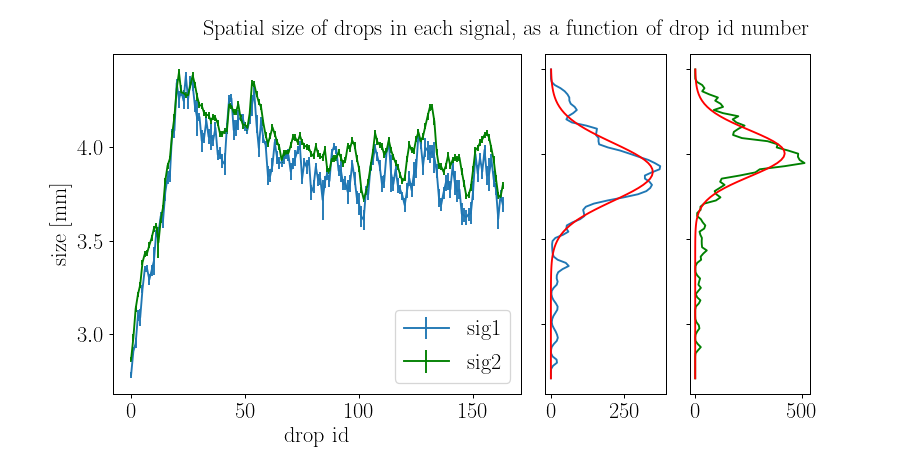

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.22it/s]
<ipython-input-137-c34510fce8cc>:50: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [146]:
title = 'Spatial size of drops in each signal, as a function of drop id number'
xlabel = 'drop id'
ylabel = 'size [mm]'
bins=100

f5, s_s_fit_1, sigma_s_s_fit_1, s_s_fit_2, sigma_s_s_fit_2 = double_histo_plot(bins, v_1=t_size_1*v_mid, v_2=t_size_2*v_mid, 
                                                                    title=title, xlabel=xlabel, ylabel=ylabel)

subname = 'space_size'
f5.savefig(f'{plot_dir}/{name}_{subname}.png')

r = ['spatial size [s]', s_s_fit_1.n, s_s_fit_1.s, sigma_s_s_fit_1.n, sigma_s_s_fit_1.s,
      s_s_fit_2.n, s_s_fit_2.s, sigma_s_s_fit_2.n, sigma_s_s_fit_2.s ]
with open(f'{plot_dir}/{name}_{a}.csv', mode='a', newline ='') as file:
    writer = csv.writer(file, delimiter='	', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(r)

### fiber spatial size

<IPython.core.display.Javascript object>


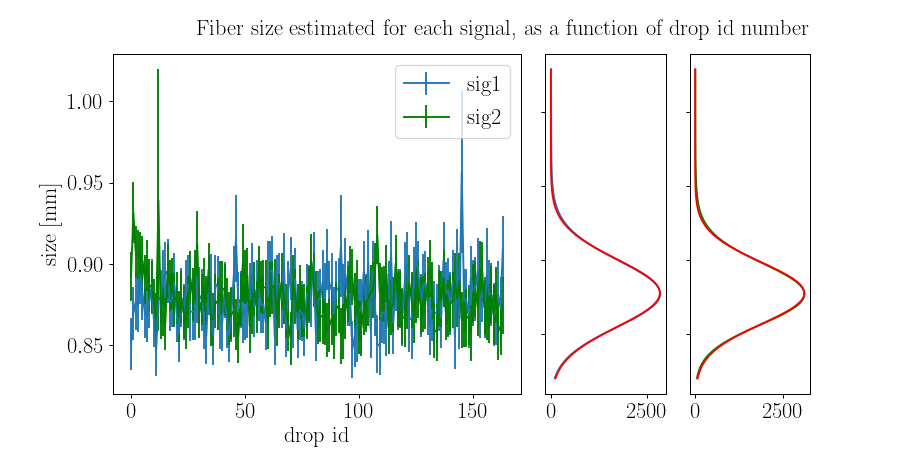

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.80it/s]
<ipython-input-137-c34510fce8cc>:50: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [193]:
title = 'Fiber size estimated for each signal, as a function of drop id number'
xlabel = 'drop id'
ylabel = 'size [mm]'
bins=100

fiber_1 = (drop_edges_1[1]-drop_edges_1[0]+drop_edges_1[3]-drop_edges_1[2])*0.5
fiber_2 = (drop_edges_2[1]-drop_edges_2[0]+drop_edges_2[3]-drop_edges_2[2])*0.5

f6, fiber_fit_1, sigma_fiber_fit_1, fiber_fit_2, sigma_fiber_fit_2 = double_histo_plot(bins, v_1=fiber_1*v_mid, v_2=fiber_2*v_mid, 
                                                                    title=title, xlabel=xlabel, ylabel=ylabel)

subname = 'fiber'
f6.savefig(f'{plot_dir}/{name}_{subname}.png')

r = ['fiber spatial size [s]', fiber_fit_1.n, fiber_fit_1.s, sigma_fiber_fit_1.n, sigma_fiber_fit_1.s,
      fiber_fit_2.n, fiber_fit_2.s, sigma_fiber_fit_2.n, sigma_fiber_fit_2.s ]
with open(f'{plot_dir}/{name}_{a}.csv', mode='a', newline ='') as file:
    writer = csv.writer(file, delimiter='	', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(r)

<IPython.core.display.Javascript object>


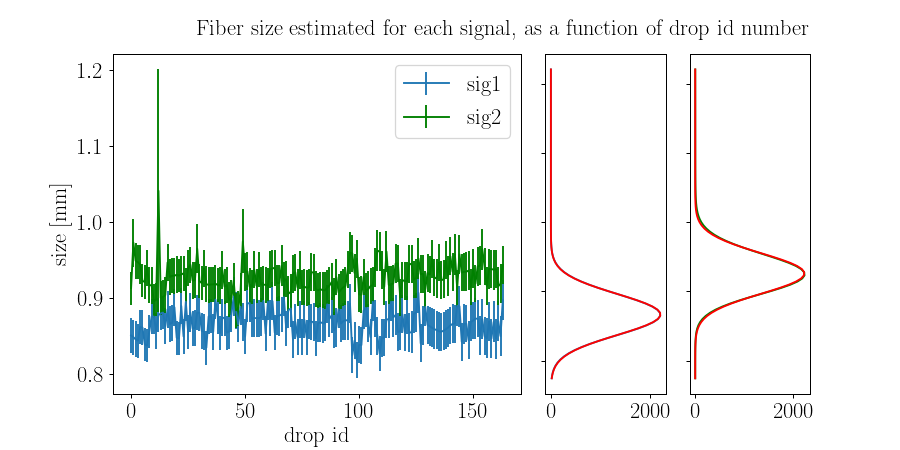

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.39it/s]
<ipython-input-137-c34510fce8cc>:50: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [194]:
title = 'Fiber size estimated for each signal, as a function of drop id number'
xlabel = 'drop id'
ylabel = 'size [mm]'
bins=100

fiber_1 = drop_edges_1[1]-drop_edges_1[0]
fiber_2 = drop_edges_2[1]-drop_edges_2[0]

f6, fiber_fit_1, sigma_fiber_fit_1, fiber_fit_2, sigma_fiber_fit_2 = double_histo_plot(bins, v_1=fiber_1*v_mid, v_2=fiber_2*v_mid, 
                                                                    title=title, xlabel=xlabel, ylabel=ylabel)

<IPython.core.display.Javascript object>


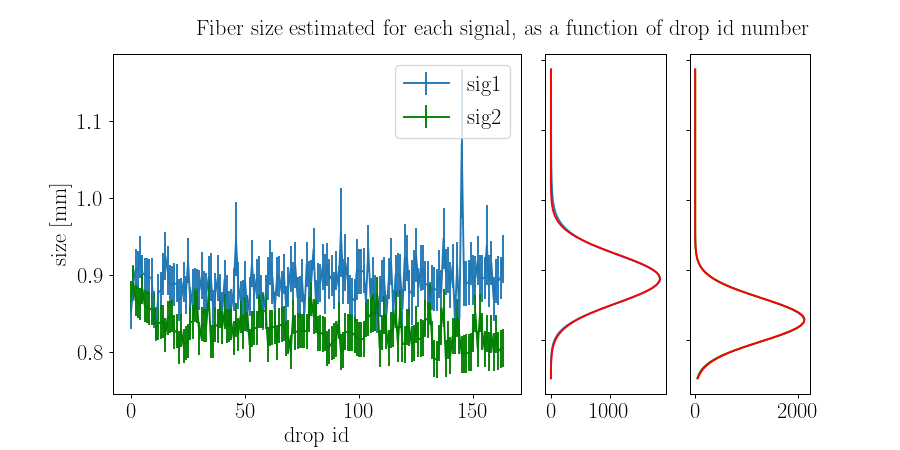

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.70it/s]
<ipython-input-137-c34510fce8cc>:50: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [195]:
title = 'Fiber size estimated for each signal, as a function of drop id number'
xlabel = 'drop id'
ylabel = 'size [mm]'
bins=100

fiber_1 = drop_edges_1[3]-drop_edges_1[2]
fiber_2 = drop_edges_2[3]-drop_edges_2[2]

f6, fiber_fit_1, sigma_fiber_fit_1, fiber_fit_2, sigma_fiber_fit_2 = double_histo_plot(bins, v_1=fiber_1*v_mid, v_2=fiber_2*v_mid, 
                                                                    title=title, xlabel=xlabel, ylabel=ylabel)